In [409]:
from openseespy.opensees import *
import matplotlib.pyplot as plt
import numpy as np
import opsvis as opsv
%matplotlib widget

In [410]:
wipe() 
model('basic', '-ndm', 2, '-ndf', 3)

In [411]:
# CREATE NODES
B = 8000
H = 3600
node(1, 0, 0)           # Bottom left (fix)
node(2, 0, 500)         # node
node(3, 0, H + 500)     # Top left
node(4, B, 0)           # Bottom right (fix)
node(5, B, 500)         # Node 5
node(6, B, H + 500)     # Top right

node(7, 0, 500)         # left BRB, bottom end
node(8, B/2, 500)       # center steel bracket at bottom
node(9, B, 500)         # right BRB, bottom end

node(10, B/2, H+500)    # BRBs top end
node(11, B/2, H+500)    # Top beam center

node(12, B/2, 0)        # center steel bracket at bottom  (fix)

In [412]:
fix(1, 1, 1, 1)
fix(4, 1, 1, 1)
fix(12, 1, 1, 1)

<Axes: >

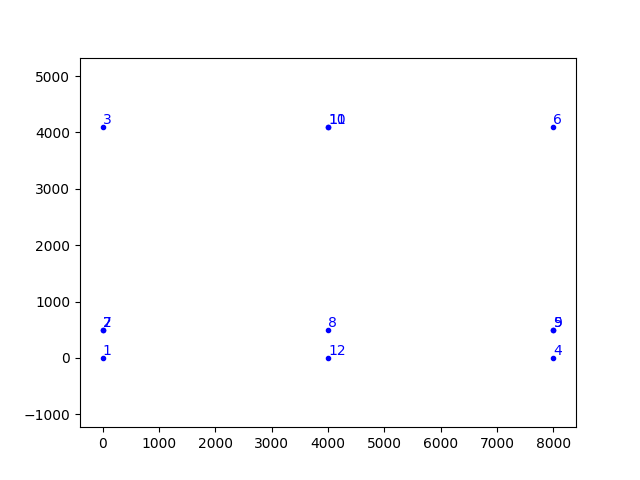

In [413]:
opsv.plot_model()

#### CREATE MATERIALS AND ELEMENTS

In [414]:
mat_list = {}
def new_mat(matName):
    mat_list[matName] = len(mat_list.keys()) + 1
    return int(mat_list[matName])

def new_ele():
    return getNumElements()[0] + 1

In [415]:
# Beam
h_beam = 585.0
b_beam = 315.0
A_beam = h_beam * b_beam
Iz_beam = b_beam * (h_beam)**3 / 12
E = 10000.0e6 # MPa
beam_nodes = [[7, 8], [8, 9], [3, 11], [11, 6]]
geomTransf('Linear', 1)

# element('elasticBeamColumn', eleTag, *eleNodes, Area, E_mod, Iz, transfTag)
for each in beam_nodes:
    element('elasticBeamColumn', new_ele(), *each, A_beam, E, Iz_beam, 1, '-release', 3)

In [416]:
# Column
# element('elasticBeamColumn', eleTag, *eleNodes, Area, E_mod, Iz, transfTag)

d1_col = 315.0
d2_col = 315.0
A_col = d1_col * d2_col
Iz_col = d1_col * (d2_col)**3 / 12
col_nodes = [[1,2], [2,3], [4,5], [5,6]]

geomTransf('PDelta', 2)
for each in col_nodes:
    element('elasticBeamColumn', new_ele(), *each, A_col, E, Iz_col, 2, '-release', 3)

In [417]:
## Buckling Restrained Braces (BRBs)
# Steel core
# uniaxialMaterial('Steel4', matTag, Fy, E0, '-kin', b_k, *params, b_kc, R_0c, r_1c, r_2c, '-iso', b_i, rho_i, b_l, R_i, l_yp, b_ic, rho_ic, b_lc, R_ic, '-ult', f_u, R_u, f_uc, R_uc)
uniaxialMaterial('Steel4', new_mat("brbSteelCore"), 
    294.0,                                  # fy
    256200.0,                               # Eeq
    '-kin', 0.004,                          # bk_tension
    25.0, 0.91, 0.15,                       # R0, r1, r2 (tension)
    0.025, 25.0, 0.91, 0.15,                # bk_compression, R0c, r1c, r2c
    '-iso', 0.0008, 1.39, 0.0007, 3.0, 1.0, # bi, rho_it, bl, Ri, lyp
            0.0008, 1.03, 0.0007, 3.0,      # bi_c, rho_ic, bl_c, Ri_c
    '-ult', 485.0, 2.0, 735.0, 2.0          # fu_t, Ru_t, fu_c, Ru_c
)
# For elastoplastic spring to model additional restraints
# uniaxialMaterial('Steel01', matTag, Fy, E0, b, a1, a2, a3, a4)
uniaxialMaterial('Steel01', new_mat("brbSpring"),          
                 27000*4.6,                 # Fy = E0 * yield_displacement
                 27000,                     # E0
                 0.10)                      # post-yield hardening ratio

In [418]:
# BRB
# element('Truss', eleTag, *eleNodes, A, matTag)
# element('twoNodeLink', eleTag, *eleNodes, '-mat', *matTags, '-dir', *dir)

element('Truss', new_ele(), *[7, 10], 1120, mat_list['brbSteelCore'])
element('twoNodeLink', new_ele(), *[7,10], '-mat', mat_list['brbSpring'], '-dir', 1)
element('Truss', new_ele(), *[9, 10], 1120, mat_list['brbSteelCore'])
element('twoNodeLink', new_ele(), *[9,10], '-mat', mat_list['brbSpring'], '-dir', 1)

<Axes: >

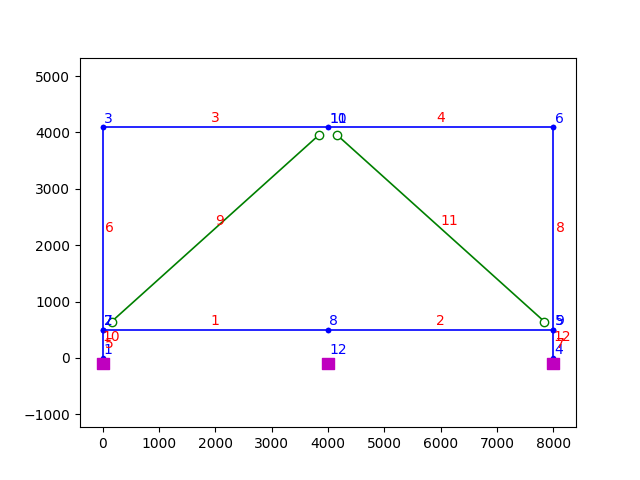

In [419]:
opsv.plot_model()

In [ ]:
# Dowelled connection - Pinching4 to model cyclic hysteresis for connection

uniaxialMaterial('Pinching4', new_mat("TopDowelPinching4"),
    # Envelope points (positive)
    12028., 0.01,
    421008., 0.7, 
    774948., 2.0, 
    962000., 3.4, 
    # Envelope points (negative)
    -12028., -0.01, 
    -421008., -0.7,
    -774948., -2.0,
    -962000., -3.4,
    # Reloading rules
    0.0, 0.0, -0.05,            # rDispP, rForceP, uForceP
    0.0, 0.0, -0.05,            # rDispN, rForceN, uForceN
    # Degradation (none)
    0.0, 0.0, 0.0, 0.0, 0.0,    # gK
    0.0, 0.0, 0.0, 0.0, 0.0,    # gD
    0.0, 0.0, 0.0, 0.0, 0.0,    # gF
    0.0,                        # gE
   'energy'                   # dmgType
)

# ElasticMultiLinear - simulates initial slip in dowelled connection
uniaxialMaterial("ElasticMultiLinear", new_mat("dowelElasticMultiLinear"),
    "-strain", *[-2.0, -0.5, 0.0, 0.5, 2.0],
    "-stress", *[-2.5e7, -8000, 0.0, 8000, 2.5e7]
)


# Join the materials in series
uniaxialMaterial('Series', new_mat("TopDowelSeriesMat"), mat_list['TopDowelPinching4'], mat_list['dowelElasticMultiLinear'])

# zeroLength elements (must avoid overlapping direction assignments)
# Use Pinching4 for dir 1 (X), and ElasticMultiLinear for dir 2 (Y)
element('zeroLength', new_ele(), *[10, 11], '-mat', mat_list['TopDowelSeriesMat'], '-dir', 1)
element('zeroLength', new_ele(), *[10, 11], '-mat', mat_list['TopDowelPinching4'], '-dir', 2)

ERROR: -- input backbone is not unique (one-to-one) , Pinching4Material::Pinching4MaterialERROR: -- input backbone is not unique (one-to-one) , Pinching4Material::Pinching4MaterialERROR: -- input backbone is not unique (one-to-one) , Pinching4Material::Pinching4MaterialERROR: -- input backbone is not unique (one-to-one) , Pinching4Material::Pinching4Material

In [ ]:
# Bottom dowelled connection - Pinching4 (half-strength)

uniaxialMaterial('Pinching4', new_mat("bottomDowelPinching4"),
    # Positive envelope
    6014., 0.01,
    210504., 0.7,
    387474., 2.0,
    481000., 3.4,
    # Negative envelope (symmetric)
    -6014., -0.01,
    -210504., -0.7,
    -387474., -2.0,
    -481000., -3.4,
    # Reloading rules
    0.0, 0.0, -0.05,
    0.0, 0.0, -0.05,
    # Degradation (none)
    0.0, 0.0, 0.0, 0.0, 0.0,  # gK
    0.0, 0.0, 0.0, 0.0, 0.0,  # gD
    0.0, 0.0, 0.0, 0.0, 0.0,  # gF
    0.0,
    "energy"
)

element('zeroLength', new_ele(), *[2,7], '-mat', mat_list['bottomDowelPinching4'],mat_list['bottomDowelPinching4'], '-dir', 1,2)
element('zeroLength', new_ele(), *[5,9], '-mat', mat_list['bottomDowelPinching4'],mat_list['bottomDowelPinching4'], '-dir', 1,2)
element('twoNodeLink', new_ele(), *[8,12], '-mat', mat_list['bottomDowelPinching4'],mat_list['bottomDowelPinching4'], '-dir', 1,2)

ERROR: -- input backbone is not unique (one-to-one) , Pinching4Material::Pinching4MaterialERROR: -- input backbone is not unique (one-to-one) , Pinching4Material::Pinching4MaterialERROR: -- input backbone is not unique (one-to-one) , Pinching4Material::Pinching4MaterialERROR: -- input backbone is not unique (one-to-one) , Pinching4Material::Pinching4MaterialERROR: -- input backbone is not unique (one-to-one) , Pinching4Material::Pinching4MaterialERROR: -- input backbone is not unique (one-to-one) , Pinching4Material::Pinching4MaterialERROR: -- input backbone is not unique (one-to-one) , Pinching4Material::Pinching4Material

<Axes: >

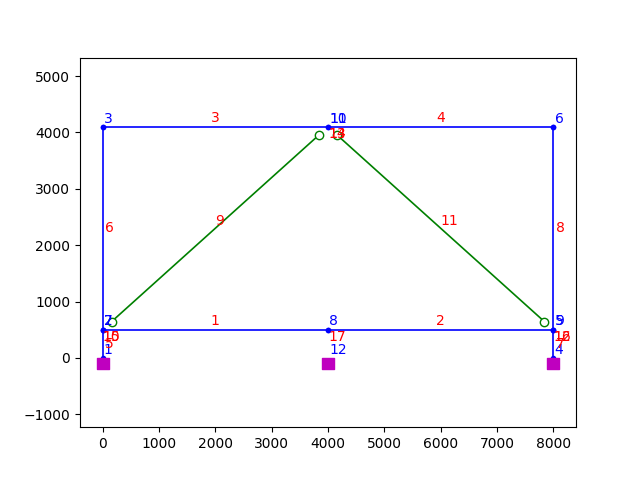

In [422]:
opsv.plot_model()

In [423]:
eigs = eigen('-genBandArpack', 2)
eigs

ProfileSPDLinDirectSolver::solve() -  aii < 0 (i, aii): (2, 0)
ArpackSolver::Error with _saupd info = -9
Starting vector is zero.
WARNING DirectIntegrationAnalysis::eigen() - EigenSOE failed in solve()
WANRING failed to do eigen analysis


OpenSeesError: See stderr output

In [ ]:
# APPLY LOADS
timeSeries('Linear', 1)
pattern('Plain', 1, 1)
load(3, 10e3, 0, 0)

In [ ]:
# SETUP ANALYSIS
constraints("Transformation")
numberer("Plain")
system("BandGeneral")
integrator("LoadControl", 0.01)
test("NormUnbalance", 1.0e-10, 100000, 50)
algorithm("Newton")
analysis("Static")

In [ ]:
# ANALYZE
analyze(100)

WARNING BandGenLinLapackSolver::solve() -factorization failed, matrix singular U(i,i) = 0, i= 2
WARNING NewtonRaphson::solveCurrentStep() -the LinearSysOfEqn failed in solve()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 0.0001
OpenSees > analyze failed, returned: -3 error flag


-3

In [ ]:
# POST-PROCESSSING ANALYSIS RESULTS

disp = nodeDisp(3, 1)
print(f"The displacement of node 3 is {disp} mm.")

In [ ]:
opsv.plot_defo()